In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt

# pytorch stuff
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
from torch.nn import functional as F


In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [4]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# Prepare Train and Test Dataset

In [5]:
# Get Data from gutenberg.org (Time Machine)
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
tm_tokens = torch.tensor(tokenizer.encode(text))

Token indices sequence length is longer than the specified maximum sequence length for this model (48533 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
# Create a dataset class
class TokenDataset(Dataset):
  def __init__(self, tokens, seq_len=8, stride=4):

    # initialize
    self.inputs = []
    self.targets = []

    for i in range(0, len(tokens)-seq_len, stride):

      self.inputs.append(tokens[i:i+seq_len])
      self.targets.append(tokens[i+1:i+seq_len+1])

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

  def __len__(self):
    return len(self.inputs)


In [7]:
len(tm_tokens)

48533

In [8]:
# Create a dataset object
token_dataset = TokenDataset(tm_tokens,8,2)

train_size = 0.9
test_size = 1-train_size
train_dataset, test_dataset = torch.utils.data.random_split(token_dataset, [train_size, test_size])

In [9]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)

In [10]:
print(f'Train Dataset Size: {len(train_dataset):,}')
print(f'Test Dataset Size: {len(test_dataset):,}')

Train Dataset Size: 21,837
Test Dataset Size: 2,426


# Create the model

In [11]:
class Model(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super().__init__()

    # Embedding Matrix
    self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)

    # embedding to output(Linear) layer
    self.GELU = nn.GELU()
    self.linear = nn.Linear(embed_dim, tokenizer.vocab_size)

  def forward(self, x):
    x = self.embedding(x)
    x = self.GELU(x)
    x = self.linear(x)
    return F.log_softmax(x, dim=-1)

  def generate(self, tokx, max_new_tokens):
    for _ in range(max_new_tokens):
      x = self(tokx)
      logits = x[:,-1,:]
      probs = torch.exp(logits)
      tokx_next = torch.multinomial(probs, num_samples=1)
      tokx = torch.cat((tokx, tokx_next), dim=1)
    return tokx

In [12]:
# Create an instance of the model
embed_dim = 64
vocab_size = tokenizer.vocab_size
model = Model(vocab_size, embed_dim)
X = token_dataset[1][0]
logits = model(X)

In [13]:
print(f'Input Shape: {X.shape}')
print(f'Output Shape: {logits.shape}')

Input Shape: torch.Size([8])
Output Shape: torch.Size([8, 50257])


In [14]:
X,y = next(iter(train_dataloader))
model.to(device)
X,y = X.to(device), y.to(device)
logits = model(X)
print(f'Input Shape: {X.shape}')
print(f'Output Shape: {logits.shape}')
print(f'Target Shape: {y.shape}')
logits.view(-1, logits.size(-1)).shape, y.view(-1).shape

Input Shape: torch.Size([64, 8])
Output Shape: torch.Size([64, 8, 50257])
Target Shape: torch.Size([64, 8])


(torch.Size([512, 50257]), torch.Size([512]))

# Create loss and optimizer

In [15]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=.01)

In [16]:
def train_model(num_epchs, model, loss_fn, optimizer, train_dataloader, test_dataloader):

  # Initialize losses
  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
    epoch_train_loss = []
    epoch_test_loss = []

    model.train() # Set model to training mode for this epoch
    for X, y in train_dataloader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      logits = model(X) # (BATCH_SIZE, SEQ_LEN, VOCAB_SIZE)

      # Reshape logits and y for NLLLoss
      loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
      loss.backward()
      optimizer.step()
      epoch_train_loss.append(loss.item())

    model.eval() # Set model to evaluation mode
    with torch.no_grad():
      for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X) # (BATCH_SIZE, SEQ_LEN, VOCAB_SIZE)
        # Reshape logits and y for NLLLoss
        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
        epoch_test_loss.append(loss.item())

    # Append average epoch losses
    train_losses.append(np.mean(epoch_train_loss))
    test_losses.append(np.mean(epoch_test_loss))

  return train_losses, test_losses

In [ ]:
num_epochs = 50
model.to(device)
train_losses, test_losses = train_model(num_epochs, model, loss_fn, optimizer, train_dataloader, test_dataloader)

# Visualize the losses

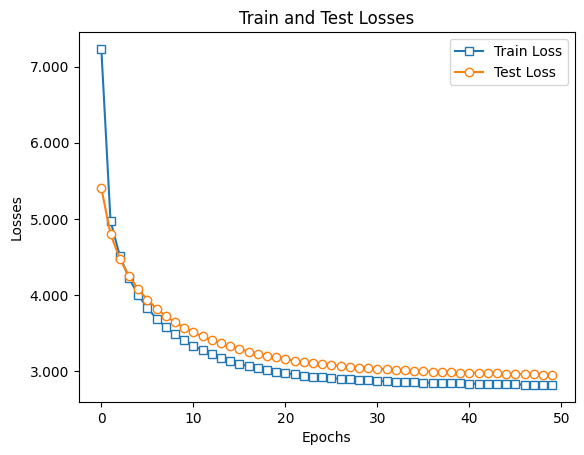

In [ ]:
from matplotlib.ticker import StrMethodFormatter
plt.plot(train_losses, 's-',markerfacecolor='w',label='Train Loss')
plt.plot(test_losses, 'o-',markerfacecolor='w',label='Test Loss')
plt.gca().set(xlabel='Epochs',ylabel='Losses',title='Train and Test Losses')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # Format y-axis labels with commas
plt.legend()
plt.show()

# Generate new text

In [ ]:
new_text = 'I am loving this Python code'
start_tokens = torch.tensor(tokenizer.encode(new_text)).unsqueeze(0)
start_tokens = start_tokens.to(device)
generated_tokens = model.generate(start_tokens, max_new_tokens=20)
generated_text = tokenizer.decode(generated_tokens[0].tolist())
print(generated_text.replace('\r','\n'))

I am loving this Python code motionless fire, I saw an incessantasm





“I suppose


In [17]:
# Recreate an instance of the model with embed_dim = 768
embed_dim = 768
vocab_size = tokenizer.vocab_size
model = Model(vocab_size=vocab_size, embed_dim=embed_dim)
model.to(device)

Model(
  (embedding): Embedding(50257, 768)
  (GELU): GELU(approximate='none')
  (linear): Linear(in_features=768, out_features=50257, bias=True)
)

# Compare GPT2 model with the current model

In [18]:
from transformers import AutoModelForCausalLM
gpt2 = AutoModelForCausalLM.from_pretrained('gpt2')
gpt2.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [19]:
print(f'{'GPT-2 Embedding shape':32}: {gpt2.transformer.wte.weight.shape}')
print(f'{'Current Model Embedding shape':32}: {model.embedding.weight.shape}')

GPT-2 Embedding shape           : torch.Size([50257, 768])
Current Model Embedding shape   : torch.Size([50257, 768])


In [20]:
gpt2.transformer.wte.weight - model.embedding.weight

tensor([[ 0.6159,  0.9322, -1.6887,  ..., -0.2337, -0.5764,  1.1105],
        [-0.5309, -1.4275,  1.3566,  ...,  2.6702, -0.2977,  1.0211],
        [ 0.9837,  0.9225,  1.2608,  ...,  1.0943, -1.5647,  0.1305],
        ...,
        [-0.0907, -0.1319,  1.2801,  ..., -1.6372,  1.3954,  2.0298],
        [ 0.0304,  0.2853, -1.7463,  ...,  0.8103,  0.4457,  1.2401],
        [ 0.4324,  0.5061, -0.8221,  ...,  1.2302, -1.1656,  0.5838]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [21]:
torch.allclose(gpt2.transformer.wte.weight, model.embedding.weight)

False

In [22]:
# Copy GPT-2 embedding weights to current model
model.embedding.weight.data = gpt2.transformer.wte.weight.data

In [23]:
torch.allclose(gpt2.transformer.wte.weight, model.embedding.weight)

True

In [24]:
!pip install torchinfo
from torchinfo import summary

In [39]:
summary(model, input_size=(1,8), device=device, dtypes=[torch.long], col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
Model (Model)                            [1, 8]                    [1, 8, 50257]             --                        Partial
├─Embedding (embedding)                  [1, 8]                    [1, 8, 768]               (38,597,376)              False
├─GELU (GELU)                            [1, 8, 768]               [1, 8, 768]               --                        --
├─Linear (linear)                        [1, 8, 768]               [1, 8, 50257]             38,647,633                True
Total params: 77,245,009
Trainable params: 38,647,633
Non-trainable params: 38,597,376
Total mult-adds (Units.MEGABYTES): 77.25
Input size (MB): 0.00
Forward/backward pass size (MB): 3.27
Params size (MB): 308.98
Estimated Total Size (MB): 312.25

In [38]:
# Freeze the gradients of the model
model.embedding.weight.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3, weight_decay=1e-2)


In [40]:
# Re-train the model
num_epochs = 50
train_losses_emb_frozen, test_losses_emb_frozen = train_model(num_epochs, model, loss_fn, optimizer, train_dataloader, test_dataloader)


In [41]:
# Un-Freeze the gradients of the model
model.embedding.weight.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)


In [42]:
# Re-train the model
train_losses_emb_unfrozen, test_losses_emb_unfrozen = train_model(50, model, loss_fn, optimizer, train_dataloader, test_dataloader)


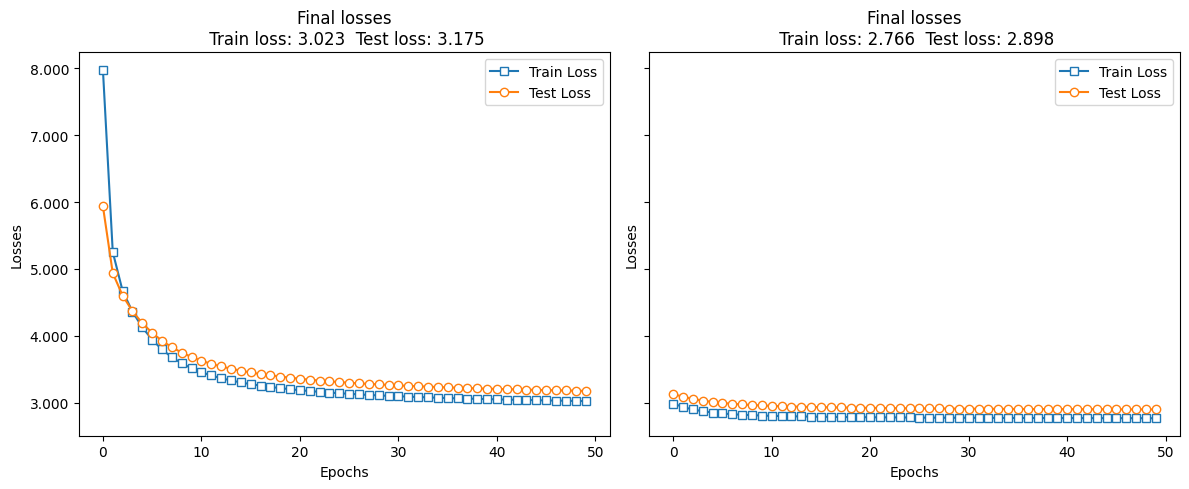

In [49]:
from matplotlib.ticker import StrMethodFormatter
_, axs = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)

axs[0].plot(train_losses_emb_frozen, 's-',markerfacecolor='w',label='Train Loss')
axs[0].plot(test_losses_emb_frozen, 'o-',markerfacecolor='w',label='Test Loss')
axs[0].set(xlabel='Epochs',ylabel='Losses',title=f'Final losses\n Train loss: {train_losses_emb_frozen[-1]:.3f}  Test loss: {test_losses_emb_frozen[-1]:.3f}')
axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # Format y-axis labels with commas

axs[1].plot(train_losses_emb_unfrozen, 's-',markerfacecolor='w',label='Train Loss')
axs[1].plot(test_losses_emb_unfrozen, 'o-',markerfacecolor='w',label='Test Loss')
axs[1].set(xlabel='Epochs',ylabel='Losses',title=f'Final losses\n Train loss: {train_losses_emb_unfrozen[-1]:.3f}  Test loss: {test_losses_emb_unfrozen[-1]:.3f}')

axs[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # Format y-axis labels with commas

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()